# Create summary data in excel

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os.path

import dotenv
import pandas as pd
import scmdata
import scmdata.database

import utils

<IPython.core.display.Javascript object>

/data/ubuntu-znicholls/miniconda3/envs/one-earth-2022/lib/python3.7/site-packages/scmdata/database.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


<IPython.core.display.Javascript object>

In [3]:
dotenv.load_dotenv()

True

<IPython.core.display.Javascript object>

In [4]:
OUT_FILE = os.path.join(
    utils.DATA_DIR,
    "processed",
    "summary",
    "data-summary-{}.xlsx".format(utils.SCENARIO_CREATION_ID),
)

<IPython.core.display.Javascript object>

In [5]:
HARMONISED_INFILLED_SCENARIOS_FILE = os.path.join(
    utils.DATA_DIR,
    "processed",
    "harmonised-infilled-scenarios",
    "harmonised-infilled-emissions.nc",
)

<IPython.core.display.Javascript object>

In [6]:
RCMIP_EMISSIONS_FILE = os.path.join(
    utils.DATA_DIR,
    "raw",
    "rcmip",
    "rcmip-emissions-annual-means-v5-1-0.csv",
)

<IPython.core.display.Javascript object>

In [7]:
MAGICC_QUANTILES_FILE = os.path.join(
    utils.DATA_DIR,
    "processed",
    "magicc-output",
    utils.MAGICC_RUN_ID,
    "magicc-output-quantiles.nc",
)
MAGICC_QUANTILES_FILE

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/processed/magicc-output/7d7c42/magicc-output-quantiles.nc'

<IPython.core.display.Javascript object>

In [8]:
CO2_EMISSIONS_BREAKDOWN_FILE = os.path.join(
    utils.DATA_DIR,
    "processed",
    "crunched-scenarios",
    "co2-emissions-breakdown-{}.csv".format(utils.SCENARIO_CREATION_ID),
)

<IPython.core.display.Javascript object>

In [9]:
emission_input = utils.unmangle_scenario_name(
    scmdata.ScmRun.from_nc(HARMONISED_INFILLED_SCENARIOS_FILE)
)
emission_input

<ScmRun (timeseries: 4160, timepoints: 89)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2103-01-01T00:00:00
Meta:
	      co2_landuse_baseline_model co2_landuse_baseline_scenario  \
	0                    IMAGE 3.0.1                 SSP1-Baseline   
	1                    IMAGE 3.0.1                 SSP1-Baseline   
	2                    IMAGE 3.0.1                 SSP1-Baseline   
	3                    IMAGE 3.0.1                 SSP1-Baseline   
	4                    IMAGE 3.0.1                 SSP1-Baseline   
	...                          ...                           ...   
	4155  Idealised from IMAGE 3.0.1        End deforestation 2050   
	4156  Idealised from IMAGE 3.0.1        End deforestation 2050   
	4157  Idealised from IMAGE 3.0.1        End deforestation 2050   
	4158  Idealised from IMAGE 3.0.1        End deforestation 2050   
	4159  Idealised from IMAGE 3.0.1        End deforestation 2050   
	
	     landuse_pathways_quantile           model nonco2_landuse_baseline_model  \
	0 

<IPython.core.display.Javascript object>

In [10]:
rcmip_emms = scmdata.ScmRun(
    RCMIP_EMISSIONS_FILE,
    lowercase_cols=True,
)
historical_data = rcmip_emms.filter(scenario="ssp245", year=range(1750, 2014 + 1))
historical_data["scenario"] = "historical"
historical_data_openscm_runner = utils.rcmip_to_openscm_runner(
    historical_data.filter(region="World")
).filter(variable=emission_input.get_unique_meta("variable"))

assert historical_data_openscm_runner.shape[0] == len(
    emission_input.get_unique_meta("variable")
)

for vu in emission_input.groupby(["variable", "unit"]):
    v = vu.get_unique_meta("variable", True)
    u = vu.get_unique_meta("unit", True)
    historical_data_openscm_runner = historical_data_openscm_runner.convert_unit(
        u, variable=v, context="NH3_conversions"
    ).drop_meta("unit_context")

historical_data_openscm_runner

<ScmRun (timeseries: 52, timepoints: 265)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2014-01-01T00:00:00
Meta:
	       activity_id mip_era            model region    scenario  \
	0   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	1   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	2   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	3   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	4   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	5   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	6   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	7   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	8   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	9   not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	10  not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	11  not_applicable   CMIP6  MESSAGE-GLOBIOM  World  historical   
	12  not_applicable 

<IPython.core.display.Javascript object>

In [11]:
emissions_magicc = emission_input.append_timewise(
    historical_data_openscm_runner, ["variable", "unit"]
).resample("AS")

for sdf in emissions_magicc.groupby(
    [
        "scenario",
        "co2_landuse_baseline_model",
        "co2_landuse_baseline_scenario",
        "landuse_pathways_quantile",
        "nonco2_landuse_baseline_model",
        "nonco2_landuse_baseline_scenario",
    ]
):
    assert sdf.shape[0] == 52
    assert set(sdf.get_unique_meta("variable")) == set(
        emission_input.get_unique_meta("variable")
    )

emissions_magicc

<ScmRun (timeseries: 4160, timepoints: 354)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2103-01-01T00:00:00
Meta:
	      co2_landuse_baseline_model co2_landuse_baseline_scenario  \
	0                    IMAGE 3.0.1                 SSP1-Baseline   
	1                    IMAGE 3.0.1                 SSP1-Baseline   
	2                    IMAGE 3.0.1                 SSP1-Baseline   
	3                    IMAGE 3.0.1                 SSP1-Baseline   
	4                    IMAGE 3.0.1                 SSP1-Baseline   
	...                          ...                           ...   
	4155  Idealised from IMAGE 3.0.1        End deforestation 2050   
	4156  Idealised from IMAGE 3.0.1        End deforestation 2050   
	4157  Idealised from IMAGE 3.0.1        End deforestation 2050   
	4158  Idealised from IMAGE 3.0.1        End deforestation 2050   
	4159  Idealised from IMAGE 3.0.1        End deforestation 2050   
	
	     landuse_pathways_quantile           model nonco2_landuse_baseline_model  \
	0

<IPython.core.display.Javascript object>

In [12]:
emissions_breakdown = scmdata.ScmRun(CO2_EMISSIONS_BREAKDOWN_FILE)
emissions_breakdown = emissions_breakdown.append(
    emissions_breakdown.filter(variable="Emissions|CO2|MAGICC AFOLU").add(
        emissions_breakdown.filter(
            variable="Emissions|CO2|MAGICC Fossil and Industrial"
        ),
        op_cols={"variable": "Emissions|CO2"},
    )
)
emissions_breakdown["variable"] = emissions_breakdown["variable"].map(
    {
        "Emissions|CO2|MAGICC Fossil and Industrial": "Emissions|CO2|MAGICC Fossil and Industrial",
        "Emissions|CO2|AFOLU|No model reported sinks": "Emissions|CO2|MAGICC AFOLU|No IAM-reported sinks",
        "Uptake|CO2": "Emissions|CO2|MAGICC AFOLU|One Earth uptake",
        "Emissions|CO2|MAGICC AFOLU": "Emissions|CO2|MAGICC AFOLU",
        "Emissions|CO2": "Emissions|CO2",
    }
)
display(emissions_breakdown.get_unique_meta("variable"))
emissions_breakdown

['Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|CO2|MAGICC AFOLU|No IAM-reported sinks',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CO2|MAGICC AFOLU|One Earth uptake',
 'Emissions|CO2']

<ScmRun (timeseries: 400, timepoints: 89)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2103-01-01T00:00:00
Meta:
	     co2_landuse_baseline_model co2_landuse_baseline_scenario  \
	0                   IMAGE 3.0.1                 SSP1-Baseline   
	1                   IMAGE 3.0.1                 SSP1-Baseline   
	2                   IMAGE 3.0.1                 SSP1-Baseline   
	3                   IMAGE 3.0.1                 SSP1-Baseline   
	4                   IMAGE 3.0.1                 SSP1-Baseline   
	..                          ...                           ...   
	395  Idealised from IMAGE 3.0.1        End deforestation 2050   
	396  Idealised from IMAGE 3.0.1        End deforestation 2050   
	397  Idealised from IMAGE 3.0.1        End deforestation 2050   
	398  Idealised from IMAGE 3.0.1        End deforestation 2050   
	399  Idealised from IMAGE 3.0.1        End deforestation 2050   
	
	    landuse_pathways_quantile           model nonco2_landuse_baseline_model  \
	0               

<IPython.core.display.Javascript object>

In [13]:
magicc_output = utils.unmangle_scenario_name(
    scmdata.ScmRun.from_nc(MAGICC_QUANTILES_FILE)
)
magicc_output

<ScmRun (timeseries: 1200, timepoints: 401)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2150-01-01T00:00:00
Meta:
	     climate_model  co2_landuse_baseline_model co2_landuse_baseline_scenario  \
	0     MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	1     MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	2     MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	3     MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	4     MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	...            ...                         ...                           ...   
	1195  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	1196  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	1197  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	1198  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050  

<IPython.core.display.Javascript object>

In [14]:
magicc_temperatures = magicc_output.filter(
    variable="Surface Air Temperature Change", quantile=0.5
)
magicc_temperatures["variable"] = "Median " + magicc_temperatures["variable"]
magicc_temperatures = magicc_temperatures.drop_meta("quantile")
magicc_temperatures

<ScmRun (timeseries: 80, timepoints: 401)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2150-01-01T00:00:00
Meta:
	     climate_model  co2_landuse_baseline_model co2_landuse_baseline_scenario  \
	8     MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	23    MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	38    MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	53    MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	68    MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	...            ...                         ...                           ...   
	1133  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	1148  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	1163  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	1178  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   


<IPython.core.display.Javascript object>

In [15]:
magicc_fluxes = magicc_output.filter(variable="*Flux*", quantile=0.5)
magicc_fluxes["variable"] = "Median " + magicc_fluxes["variable"]
magicc_fluxes = magicc_fluxes.drop_meta("quantile")
magicc_fluxes

<ScmRun (timeseries: 160, timepoints: 401)>
Time:
	Start: 1750-01-01T00:00:00
	End: 2150-01-01T00:00:00
Meta:
	     climate_model  co2_landuse_baseline_model co2_landuse_baseline_scenario  \
	6     MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	7     MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	21    MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	22    MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	36    MAGICCv7.5.3                 IMAGE 3.0.1                 SSP1-Baseline   
	...            ...                         ...                           ...   
	1162  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	1176  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	1177  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	1191  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   

<IPython.core.display.Javascript object>

In [16]:
emissions_breakdown = emissions_breakdown.append(
    magicc_fluxes.filter(time=emissions_breakdown["time"].tolist())
)
display(emissions_breakdown.get_unique_meta("variable"))
emissions_breakdown["landuse_pathways_quantile"] = emissions_breakdown[
    "landuse_pathways_quantile"
]  # .astype(float)
emissions_breakdown

['Emissions|CO2|MAGICC Fossil and Industrial',
 'Emissions|CO2|MAGICC AFOLU|No IAM-reported sinks',
 'Emissions|CO2|MAGICC AFOLU',
 'Emissions|CO2|MAGICC AFOLU|One Earth uptake',
 'Emissions|CO2',
 'Median Net Atmosphere to Land Flux|CO2',
 'Median Net Atmosphere to Ocean Flux|CO2']

<ScmRun (timeseries: 560, timepoints: 89)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2103-01-01T00:00:00
Meta:
	    climate_model  co2_landuse_baseline_model co2_landuse_baseline_scenario  \
	0             NaN                 IMAGE 3.0.1                 SSP1-Baseline   
	1             NaN                 IMAGE 3.0.1                 SSP1-Baseline   
	2             NaN                 IMAGE 3.0.1                 SSP1-Baseline   
	3             NaN                 IMAGE 3.0.1                 SSP1-Baseline   
	4             NaN                 IMAGE 3.0.1                 SSP1-Baseline   
	..            ...                         ...                           ...   
	555  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	556  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	557  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	558  MAGICCv7.5.3  Idealised from IMAGE 3.0.1        End deforestation 2050   
	559  MAGIC

<IPython.core.display.Javascript object>

In [17]:
emissions_breakdown["co2_landuse_baseline_scenario"].unique()

array(['SSP1-Baseline', 'End deforestation 2030',
       'End deforestation 2035', 'End deforestation 2040',
       'End deforestation 2050'], dtype=object)

<IPython.core.display.Javascript object>

In [18]:
OUT_FILE_LAND_USE_PATHWAYS = os.path.join(
    utils.DATA_DIR, "processed", "summary", "land-use-pathways.csv"
)
os.makedirs(os.path.dirname(OUT_FILE_LAND_USE_PATHWAYS), exist_ok=True)

<IPython.core.display.Javascript object>

In [19]:
landuse_pathways = scmdata.ScmRun(OUT_FILE_LAND_USE_PATHWAYS)
landuse_pathways["pathway"] = landuse_pathways["variable"]
landuse_pathways["variable"] = "Uptake|CO2"
landuse_pathways.timeseries()

time                                                                                     2020-01-01  \
model     pathway            quantile region    scenario            unit     variable                 
One Earth Agroforestry       0.05     Temperate Climate restoration GtC / yr Uptake|CO2         0.0   
                                      Tropics   Climate restoration GtC / yr Uptake|CO2         0.0   
                                      World     Climate restoration GtC / yr Uptake|CO2         0.0   
          Forest Restoration 0.05     Boreal    Climate restoration GtC / yr Uptake|CO2         0.0   
                                      Temperate Climate restoration GtC / yr Uptake|CO2         0.0   
...                                                                                             ...   
          Reforestation      0.95     Tropics   Climate restoration GtC / yr Uptake|CO2         0.0   
                                      World     Climate restoration GtC / yr Uptake|CO2         0.0   
          Silvopasture       0.95     Temperate Climate restoration GtC / yr Uptake|CO2         0.0   
                                      Tropics   Climate restoration GtC / yr Uptake|CO2         0.0   
                                      World     Climate restoration GtC / yr Uptake|CO2         0.0   

time                                                                                     2021-01-01  \
model     pathway            quantile region    scenario            unit     variable                 
One Earth Agroforestry       0.05     Temperate Climate restoration GtC / yr Uptake|CO2         0.0   
                                      Tropics   Climate restoration GtC / yr Uptake|CO2         0.0   
                                      World     Climate restoration GtC / yr Uptake|CO2         0.0   
          Forest Restoration 0.05     Boreal    Climate restoration GtC / yr Uptake|CO2         0.0   
                                      Temperate Climate restoration GtC / yr Uptake|CO2         0.0   
...                                                                                             ...   
          Reforestation      0.95     Tropics   Climate restoration GtC / yr Uptake|CO2         0.0   
                                      World     Climate restoration GtC / yr Uptake|CO2         0.0   
          Silvopasture       0.95     Temperate Climate restoration GtC / yr Uptake|CO2         0.0   
                                      Tropics   Climate restoration GtC / yr Uptake|CO2         0.0   
                                      World     Climate restoration GtC / yr Uptake|CO2         0.0   

time                                                                                     2022-01-01  \
model     pathway            quantile region    scenario            unit     variable                 
One Earth Agroforestry       0.05     Temperate Climate restoration GtC / yr Uptake|CO2         0.0   
                                      Tropics   Climate restoration GtC / yr Uptake|CO2         0.0   
                                      World     Climate restoration GtC / yr Uptake|CO2         0.0   
          Forest Restoration 0.05     Boreal    Climate restoration GtC / yr Uptake|CO2         0.0   
                                      Temperate Climate restoration GtC / yr Uptake|CO2         0.0   
...                                                                                             ...   
          Reforestation      0.95     Tropics   Climate restoration GtC / yr Uptake|CO2         0.0   
                                      World     Climate restoration GtC / yr Uptake|CO2         0.0   
          Silvopasture       0.95     Temperate Climate restoration GtC / yr Uptake|CO2         0.0   
                                      Tropics   Climate restoration GtC / yr Uptake|CO2         0.0   
                                      World     Climate restoration GtC / yr Uptake|

<IPython.core.display.Javascript object>

In [20]:
OUT_FILE_PATHWAYS_R5 = os.path.join(
    utils.DATA_DIR, "processed", "summary", "land-use-pathways-r5.csv"
)

<IPython.core.display.Javascript object>

In [21]:
landuse_pathways_r5 = scmdata.ScmRun(OUT_FILE_PATHWAYS_R5)
landuse_pathways_r5["pathway"] = "All"
landuse_pathways_r5.timeseries()

time                                                                       2020-01-01  \
model     pathway quantile region scenario            unit     variable                 
One Earth All     0.05     R5ASIA Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5LAM  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5MAF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5OECD Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5REF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           World  Climate restoration GtC / yr Uptake|CO2         0.0   
                  0.17     R5ASIA Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5LAM  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5MAF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5OECD Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5REF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           World  Climate restoration GtC / yr Uptake|CO2         0.0   
                  0.50     R5ASIA Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5LAM  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5MAF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5OECD Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5REF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           World  Climate restoration GtC / yr Uptake|CO2         0.0   
                  0.83     R5ASIA Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5LAM  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5MAF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5OECD Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5REF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           World  Climate restoration GtC / yr Uptake|CO2         0.0   
                  0.95     R5ASIA Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5LAM  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5MAF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5OECD Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5REF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           World  Climate restoration GtC / yr Uptake|CO2         0.0   

time                                                                       2021-01-01  \
model     pathway quantile region scenario            unit     variable                 
One Earth All     0.05     R5ASIA Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5LAM  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5MAF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5OECD Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5REF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           World  Climate restoration GtC / yr Uptake|CO2         0.0   
                  0.17     R5ASIA Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5LAM  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5MAF  Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5OECD Climate restoration GtC / yr Uptake|CO2         0.0   
                           R5REF  Climate restoration GtC / yr Uptake|CO2         0

<IPython.core.display.Javascript object>

In [22]:
out = scmdata.run_append(
    [
        emissions_magicc,
        landuse_pathways,
        landuse_pathways_r5,
    ]
).filter(year=range(1, 2100 + 1))
out = out.interpolate(out["time"])
out.timeseries(
    [
        "model",
        "scenario",
        "nonco2_landuse_baseline_model",
        "nonco2_landuse_baseline_scenario",
        "co2_landuse_baseline_model",
        "co2_landuse_baseline_scenario",
        "landuse_pathways_quantile",
        "region",
        "pathway",
        "variable",
        "quantile",
        "unit",
    ],
    time_axis="year",
)

time                                                                                                                                                                                                                                    1750  \
model          scenario            nonco2_landuse_baseline_model nonco2_landuse_baseline_scenario co2_landuse_baseline_model co2_landuse_baseline_scenario landuse_pathways_quantile region pathway variable     quantile unit                 
One Earth 2021 One Earth 2021      IMAGE_3_0_1                   IMA15-TOT                        IMAGE 3.0.1                SSP1-Baseline                 0.05                      World  NaN     Emissions|BC NaN      Mt BC/yr  2.097771   
                                   MESSAGEix-GLOBIOM_1_0         LowEnergyDemand                  IMAGE 3.0.1                SSP1-Baseline                 0.05                      World  NaN     Emissions|BC NaN      Mt BC/yr  2.097771   
                                   UTS                           S2                               IMAGE 3.0.1                SSP1-Baseline                 0.05                      World  NaN     Emissions|BC NaN      Mt BC/yr  2.097771   
                                                                 S2-delayed                       IMAGE 3.0.1                SSP1-Baseline                 0.05                      World  NaN     Emissions|BC NaN      Mt BC/yr  2.097771   
                                   IMAGE_3_0_1                   IMA15-TOT                        IMAGE 3.0.1                SSP1-Baseline                 0.5                       World  NaN     Emissions|BC NaN      Mt BC/yr  2.097771   
...                                                                                                                                                                                                                                      ...   
One Earth      Climate restoration NaN                           NaN                              NaN                        NaN                           NaN                       R5LAM  All     Uptake|CO2   0.95     GtC / yr  0.000000   
                                                                                                                                                                                     R5MAF  All     Uptake|CO2   0.95     GtC / yr  0.000000   
                                                                                                                                                                                     R5OECD All     Uptake|CO2   0.95     GtC / yr  0.000000   
                                                                                                                                                                                     R5REF  All     Uptake|CO2   0.95     GtC / yr  0.000000   
                                                                                                                                                                                     World  All     Uptake|CO2   0.95     GtC / yr  0.000000   

time                                                                                                                                                                                                                                    1751  \
model          scenario            nonco2_landuse_baseline_model nonco2_landuse_baseline_scenario co2_landuse_baseline_model co2_landuse_baseline_scenario landuse_pathways_quantile region pathway variable     quantile unit                 
One Earth 2021 One Earth 2021      IMAGE_3_0_1                   IMA15-TOT                        IMAGE 3.0.1                SSP1-Baseline                 0.05                      World  NaN     Emissions|BC NaN      Mt BC/yr  2.072926   
                                   MESSAGEix-GLOBIOM_1_0         LowEnergyDemand                  IMAGE 3.0.1                SSP1-Baseline                 0.05

<IPython.core.display.Javascript object>

In [23]:
def get_peak_year(ts):
    return ts.idxmax(axis=1)


def get_peak(ts):
    return ts.max(axis=1)


def get_net_zero(ts, min_year):
    out = (ts <= 0).idxmax(axis=1)
    out = out.astype("Int64")
    out[out == min_year] = pd.NA

    return out


def get_half_year(run, min_year, comp_year, ts_kwargs):
    run_after_min_year = run.filter(year=range(min_year, 10**4))
    run_after_min_year_rel_comp_year = run_after_min_year.timeseries(
        **ts_kwargs
    ).divide(run.filter(year=comp_year).timeseries(**ts_kwargs)[comp_year], axis=0)
    out = (run_after_min_year_rel_comp_year <= 0.5).idxmax(axis=1)
    out = out.astype("Int64")
    out[out == min_year] = pd.NA

    return out

<IPython.core.display.Javascript object>

In [24]:
emissions_breakdown = utils.update_labelling(emissions_breakdown)
emissions_breakdown["scenario"] = "RESTORE"
emissions_breakdown["model"] = "RESTORE"
display(emissions_breakdown)

<ScmRun (timeseries: 560, timepoints: 89)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2103-01-01T00:00:00
Meta:
	    climate_model ecores_quantile energy_nonco2_pathway landuse_baseline  \
	0             NaN            0.05                   UTS          default   
	1             NaN            0.05                   UTS          default   
	2             NaN            0.05                   UTS          default   
	3             NaN            0.05                   UTS          default   
	4             NaN            0.05           UTS-delayed          default   
	..            ...             ...                   ...              ...   
	555  MAGICCv7.5.3     not_applied                   LED     default-2050   
	556  MAGICCv7.5.3     not_applied                   UTS     default-2050   
	557  MAGICCv7.5.3     not_applied                   UTS     default-2050   
	558  MAGICCv7.5.3     not_applied           UTS-delayed     default-2050   
	559  MAGICCv7.5.3     not_applied          

<IPython.core.display.Javascript object>

In [25]:
emissions_breakdown

<ScmRun (timeseries: 560, timepoints: 89)>
Time:
	Start: 2015-01-01T00:00:00
	End: 2103-01-01T00:00:00
Meta:
	    climate_model ecores_quantile energy_nonco2_pathway landuse_baseline  \
	0             NaN            0.05                   UTS          default   
	1             NaN            0.05                   UTS          default   
	2             NaN            0.05                   UTS          default   
	3             NaN            0.05                   UTS          default   
	4             NaN            0.05           UTS-delayed          default   
	..            ...             ...                   ...              ...   
	555  MAGICCv7.5.3     not_applied                   LED     default-2050   
	556  MAGICCv7.5.3     not_applied                   UTS     default-2050   
	557  MAGICCv7.5.3     not_applied                   UTS     default-2050   
	558  MAGICCv7.5.3     not_applied           UTS-delayed     default-2050   
	559  MAGICCv7.5.3     not_applied          

<IPython.core.display.Javascript object>

In [26]:
summary_stats_columns = [
    "model",
    "scenario",
    "ecores_quantile",
    "landuse_baseline",
    "energy_nonco2_pathway",
]
summary_stats = {}


min_year = 2015
cumulative_ref_year = 2020
cumulative_unit = "GtCO2"
cumulative_unit = "GtC"
# cumulative_ref_year = 2014
# cumulative_unit = "GtC"
ts_kwargs = dict(time_axis="year", meta=summary_stats_columns)


def get_integralh(inp):
    return (
        inp.integrate()
        #         .relative_to_ref_period_mean(year=cumulative_ref_year)
        .convert_unit(cumulative_unit).timeseries(**ts_kwargs)
    )


# Filter for World CO2
emms_co2_world = emissions_breakdown.filter(
    variable="Emissions|CO2",
    region="World",
    #     landuse_baseline="default-2030",
    #     energy_nonco2_pathway="UTS",
)
emms_co2_world_ts_after_min_year = emms_co2_world.filter(
    year=range(min_year, 10**4)
).timeseries(**ts_kwargs)

cumulative_emms_co2_world_ts = get_integralh(emms_co2_world)

# Land-use baseline CO2
emms_co2_landuse_baseline_world = emissions_breakdown.filter(
    variable="Emissions|CO2|MAGICC AFOLU|No IAM-reported sinks",
    region="World",
    #     landuse_baseline="default-2030",
    #     energy_nonco2_pathway="UTS",
)

cumulative_emms_co2_landuse_baseline_world_ts = get_integralh(
    emms_co2_landuse_baseline_world
)

# Ecores CO2
emms_co2_ecores_world = emissions_breakdown.filter(
    variable="Emissions|CO2|MAGICC AFOLU|One Earth uptake",
    region="World",
    #     landuse_baseline="default-2030",
    #     energy_nonco2_pathway="UTS",
)

cumulative_emms_co2_ecores_world_ts = get_integralh(emms_co2_ecores_world)


# Filter for World CO2 fossil
emms_co2_fossil_world = emissions_breakdown.filter(
    variable="Emissions|CO2|*Fossil*", region="World"
)
emms_co2_fossil_world_ts_after_min_year = emms_co2_fossil_world.filter(
    year=range(min_year, 10**4)
).timeseries(**ts_kwargs)

cumulative_emms_co2_fossil_world_ts = get_integralh(emms_co2_fossil_world)

# Peak CO2 emms
peak_co2_emms = get_peak_year(emms_co2_world_ts_after_min_year)
summary_stats["Peak CO2 emissions year"] = peak_co2_emms
# display("Peak CO2 year")
# display(peak_co2_emms)


# Peak cumulative CO2 emms year
peak_cumulative_co2_emms_year = get_peak_year(cumulative_emms_co2_world_ts)
summary_stats["Peak cumulative CO2 emissions year"] = peak_cumulative_co2_emms_year
# display("Peak cumulative CO2 year")
# display(peak_co2_emms_year)


# Peak cumulative CO2 emms
peak_cumulative_co2_emms = get_peak(cumulative_emms_co2_world_ts).round(0)
summary_stats[
    "Peak cumulative CO2 emissions rel. to {} ({})".format(
        cumulative_ref_year, cumulative_unit
    )
] = peak_cumulative_co2_emms
# display("Peak cumulative CO2")
# display(peak_cumulative_co2_emms)


# 2100 cumulative CO2 emms
eoc_cumulative_co2_emms = cumulative_emms_co2_world_ts[2100].round(0)
summary_stats[
    "2100 cumulative CO2 emissions rel. to {} ({})".format(
        cumulative_ref_year, cumulative_unit
    )
] = eoc_cumulative_co2_emms
# display("2100 cumulative CO2")
# display(eoc_cumulative_co2_emms)


# 2100 cumulative CO2 land-use baseline emms
eoc_cumulative_co2_landuse_baseline_emms = (
    cumulative_emms_co2_landuse_baseline_world_ts[2100].round(0)
)
summary_stats[
    "2100 cumulative CO2 emissions from land-use baseline rel. to {} ({})".format(
        cumulative_ref_year, cumulative_unit
    )
] = eoc_cumulative_co2_landuse_baseline_emms
# display("2100 cumulative CO2 land-use baseline")
# display(eoc_cumulative_co2_landuse_baseline_emms)


# 2100 cumulative CO2 ecores emms
eoc_cumulative_co2_ecores_emms = cumulative_emms_co2_ecores_world_ts[2100].round(0)
summary_stats[
    "2100 cumulative CO2 emissions from ecosystem restoration rel. to {} ({})".format(
        cumulative_ref_year, cumulative_unit
    )
] = eoc_cumulative_co2_ecores_emms
# display("2100 cumulative CO2 land-use baseline")
# display(eoc_cumulative_co2_landuse_baseline_emms)


# Peak CO2 fossil emms
peak_co2_fossil_emms = get_peak_year(emms_co2_fossil_world_ts_after_min_year)
summary_stats["Peak CO2 fossil emissions year"] = peak_co2_fossil_emms
# display("Peak CO2 fossil year")
# display(peak_co2_fossil_emms)


# # Peak cumulative CO2 fossil emms
# peak_cumulative_co2_fossil_emms_year = get_peak_year(
#     cumulative_emms_co2_fossil_world_ts
# )
# summary_stats[
#     "Peak cumulative CO2 fossil emissions year"
# ] = peak_cumulative_co2_fossil_emms_year
# # display("Peak cumulative CO2 fossil year")
# # display(peak_cumulative_co2_fossil_emms_year)


# Half CO2 emms
comp_year = 2015
# comp_year = 2020
half_co2_year = get_half_year(
    emms_co2_world.filter(year=range(2000, 10**4)), min_year, comp_year, ts_kwargs
)
summary_stats["Half CO2 emissions rel. to {} year".format(comp_year)] = half_co2_year
# display("Half CO2 (rel. {}) year".format(comp_year))
# display(half_co2_year)

# Half CO2 fossil emms
half_co2_year = get_half_year(
    emms_co2_fossil_world.filter(year=range(2000, 10**4)),
    min_year,
    comp_year,
    ts_kwargs,
)
summary_stats[
    "Half CO2 fossil emissions rel. to {} year".format(comp_year)
] = half_co2_year
# display("Half CO2 fossil (rel. {}) year".format(comp_year))
# display(half_co2_year)

/data/ubuntu-znicholls/miniconda3/envs/one-earth-2022/lib/python3.7/site-packages/scmdata/ops.py:712: UserWarning: You are integrating data which contains nans so your result will also contain nans. Perhaps you want to remove the nans before performing the integration using a combination of :meth:`filter` and :meth:`interpolate`?
  "You are integrating data which contains nans so your result will "


<IPython.core.display.Javascript object>

In [27]:
summary_stats_out = pd.DataFrame(summary_stats).sort_index()
nan_fill = -999
summary_stats_out = (
    summary_stats_out.fillna(nan_fill)
    .astype(str)
    .apply(lambda x: x.replace(f"{nan_fill}", "Not reached"))
)
summary_stats_out.reorder_levels(summary_stats_columns).sort_index()

Peak CO2 emissions year  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway                           
RESTORE RESTORE  0.05            default          IMA15-TOT                                2015   
                                                  LED                                      2020   
                                                  UTS                                      2021   
                                                  UTS-delayed                              2024   
                                 default-2030     IMA15-TOT                                2015   
...                                                                                         ...   
                 not_applied     default-2040     UTS-delayed                              2024   
                                 default-2050     IMA15-TOT                                2015   
                                                  LED                                      2020   
                                                  UTS                                      2021   
                                                  UTS-delayed                              2024   

                                                                        Peak cumulative CO2 emissions year  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway                                      
RESTORE RESTORE  0.05            default          IMA15-TOT                                           2100   
                                                  LED                                                 2100   
                                                  UTS                                                 2100   
                                                  UTS-delayed                                         2100   
                                 default-2030     IMA15-TOT                                           2100   
...                                                                                                    ...   
                 not_applied     default-2040     UTS-delayed                                         2100   
                                 default-2050     IMA15-TOT                                           2100   
                                                  LED                                                 2100   
                                                  UTS                                                 2100   
                                                  UTS-delayed                                         2100   

                                                                        Peak cumulative CO2 emissions rel. to 2020 (GtC)  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway                                                    
RESTORE RESTORE  0.05            default          IMA15-TOT                                                        397.0   
                                                  LED                                                              366.0   
                                                  UTS                                                              345.0   
                                                  UTS-delayed                                                      374.0   
                                 default-2030     IMA15-TOT                                                        342.0   
...                                                                                                                  ...   
                 not_applied     default-2040     UTS-delayed                                                      231.0   
                                 default-2050     IMA15-TOT                                                        264.0   
                                                  LED                                                            

<IPython.core.display.Javascript object>

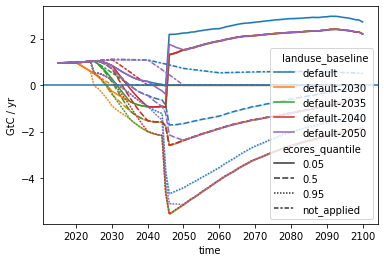

<IPython.core.display.Javascript object>

In [28]:
ax = emissions_breakdown.filter(variable="Emissions|CO2|MAGICC AFOLU").lineplot(
    hue="landuse_baseline", style="ecores_quantile"
)
ax.axhline(0)

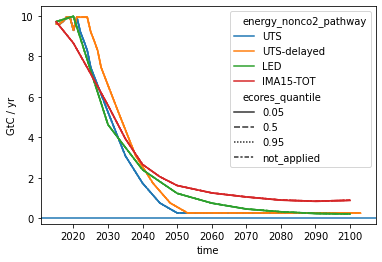

<IPython.core.display.Javascript object>

In [29]:
ax = emissions_breakdown.filter(
    variable="Emissions|CO2|MAGICC Fossil and Industrial"
).lineplot(hue="energy_nonco2_pathway", style="ecores_quantile")
ax.axhline(0)

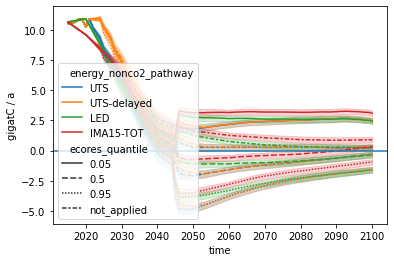

<IPython.core.display.Javascript object>

In [30]:
ax = emissions_breakdown.filter(variable="Emissions|CO2").lineplot(
    hue="energy_nonco2_pathway", style="ecores_quantile"
)
ax.axhline(0)

In [31]:
notes = pd.DataFrame(
    {
        "Compiled by": [
            "Zebedee Nicholls <zebedee.nicholls@climate-energy-college.org>"
        ],
        "Data source": [
            "Dooley et al. (One Earth, 2022) and references therein, particularly "
            "SR1.5 database (Huppmann et al., Nature Climate Change 2018) and Teske et al. (in prep., Springer, 2022) for scenarios "
            "and Meinshuasen et al. (Nature, 2009; ACP, 2011) and Nicholls et al. (in prep.) for MAGICC."
        ],
        "Citation": [
            "Note that the data is a compilation of multiple other data sources, all "
            "of which should be cited appropriately if this data compilation is used. For full "
            "details, see Dooley at al. (One Earth, 2022)."
        ],
        "Regional information": [
            "Regions follow the definitions provided at "
            "https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=10#regiondefs. "
        ],
        "Internal consistency": [
            "Some of the data provided is the sum of other data (e.g. total CO2 uptake is "
            "the sum of uptake for each pathway in each biome). However, adding up e.g. "
            "the 5th percentile from each pathway in each biome will not be exactly equal to the "
            "reported 5th percentile for total CO2 uptake. Performing such a calculation assumes "
            "perfect correlation between uncertainties in each pathway and biome, and this is "
            "not something we do. We have checked that each individual ensemble member in "
            "our Monte Carlo ensemble is internally consistent. If you require extra "
            "aggregates please contact us so that they can be calculated from the underlying "
            "ensembles, calculating aggregates from the reported statistics here will "
            "almost certainly lead to incorrect conclusions."
        ],
    }
).T.reset_index()
notes

index                                                  0
0           Compiled by  Zebedee Nicholls <zebedee.nicholls@climate-ene...
1           Data source  Dooley et al. (One Earth, 2022) and references...
2              Citation  Note that the data is a compilation of multipl...
3  Regional information  Regions follow the definitions provided at htt...
4  Internal consistency  Some of the data provided is the sum of other ...

<IPython.core.display.Javascript object>

In [32]:
def rename_variables(v):
    mapping = {
        "Emissions|CO2|MAGICC AFOLU": "Emissions|CO2|FOLU",
        "Emissions|CO2|MAGICC AFOLU|No IAM-reported sinks": "Emissions|CO2|FOLU|Land-use baseline",
        "Emissions|CO2|MAGICC AFOLU|One Earth uptake": "Emissions|CO2|FOLU|Ecosystem restoration",
        "Emissions|CO2|MAGICC Fossil and Industrial": "Emissions|CO2|Fossil and Industrial",
    }
    try:
        return mapping[v]
    except KeyError:
        return v


def get_timeseries(inrun, meta=None, update_labels=True):
    if update_labels:
        out = utils.update_labelling(inrun)
    else:
        out = inrun.copy()

    out["scenario"] = "RESTORE"
    out["model"] = "RESTORE"
    out["variable"] = out["variable"].apply(rename_variables)
    return (
        out.filter(year=range(1, 2100 + 1))
        .timeseries(time_axis="year", meta=meta)
        .sort_index()
    )


def get_timeseries_emms(inrun):
    return get_timeseries(
        inrun,
        meta=[
            "model",
            "scenario",
            "ecores_quantile",
            "landuse_baseline",
            "energy_nonco2_pathway",
            "region",
            "variable",
            "unit",
        ],
    )


def get_timeseries_baseline(inrun, update_labels=False):
    return get_timeseries(
        inrun,
        meta=[
            "model",
            "scenario",
            "ecores_quantile",
            "landuse_baseline",
            "energy_nonco2_pathway",
            "variable",
            "climate_model",
            "region",
            "unit",
        ],
        update_labels=update_labels,
    )


def get_timeseries_baseline_update_labels(inrun):
    return get_timeseries_baseline(
        inrun,
        update_labels=True,
    )


def get_timeseries_landuse_pathways(inrun):
    return get_timeseries(
        inrun,
        meta=[
            "model",
            "scenario",
            "variable",
            "region",
            "pathway",
            "unit",
            "quantile",
        ],
        update_labels=False,
    )


sheet_name_processing = (
    (
        "MAGICC Emissions",
        emissions_magicc.convert_unit("GtCO2 / yr", variable="*CO2*"),
        get_timeseries_emms,
    ),
    (
        "CO2 emissions breakdown",
        emissions_breakdown.convert_unit("GtCO2 / yr"),
        get_timeseries_baseline,
    ),
    ("Sequestration pathways R5", landuse_pathways_r5, get_timeseries_landuse_pathways),
    ("Sequestration pathways", landuse_pathways, get_timeseries_landuse_pathways),
    (
        "MAGICC Temperature Projections",
        magicc_temperatures.convert_unit("K").filter(year=range(1990, 2100 + 1)),
        get_timeseries_baseline_update_labels,
    ),
)


with pd.ExcelWriter(OUT_FILE) as writer:
    notes.to_excel(writer, sheet_name="Notes", index=False, header=False)
    summary_stats_out.to_excel(
        writer, sheet_name="Summary Statistics", merge_cells=False
    )

    for name, df, pp in sheet_name_processing:
        processed = pp(df)
        display(name)
        display(processed.head(100))
        processed.to_excel(writer, sheet_name=name, merge_cells=False)
#         break

OUT_FILE

'MAGICC Emissions'

time                                                                                                             1750  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway region variable        unit                     
RESTORE RESTORE  0.05            default          IMA15-TOT             World  Emissions|BC    Mt BC/yr      2.097771   
                                                                               Emissions|C2F6  kt C2F6/yr    0.000000   
                                                                               Emissions|C3F8  kt C3F8/yr    0.000000   
                                                                               Emissions|C4F10 kt C4F10/yr   0.000000   
                                                                               Emissions|C5F12 kt C5F12/yr   0.000000   
...                                                                                                               ...   
                                                  LED                   World  Emissions|NF3   kt NF3/yr     0.000000   
                                                                               Emissions|NH3   Mt N/yr       5.705157   
                                                                               Emissions|NOx   Mt NOx/yr    12.735212   
                                                                               Emissions|OC    Mt OC/yr     15.447668   
                                                                               Emissions|SF6   kt SF6/yr     0.000000   

time                                                                                                             1751  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway region variable        unit                     
RESTORE RESTORE  0.05            default          IMA15-TOT             World  Emissions|BC    Mt BC/yr      2.072926   
                                                                               Emissions|C2F6  kt C2F6/yr    0.000000   
                                                                               Emissions|C3F8  kt C3F8/yr    0.000000   
                                                                               Emissions|C4F10 kt C4F10/yr   0.000000   
                                                                               Emissions|C5F12 kt C5F12/yr   0.000000   
...                                                                                                               ...   
                                                  LED                   World  Emissions|NF3   kt NF3/yr     0.000000   
                                                                               Emissions|NH3   Mt N/yr       5.649529   
                                                                               Emissions|NOx   Mt NOx/yr    12.592303   
                                                                               Emissions|OC    Mt OC/yr     15.188717   
                                                                               Emissions|SF6   kt SF6/yr     0.000000   

time                                                                                                             1752  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway region variable        unit                     
RESTORE RESTORE  0.05            default          IMA15-TOT             World  Emissions|BC    Mt BC/yr      2.064312   
                                                                               Emissions|C2F6  kt C2F6/yr    0.000000   
                                                                               Emissions|C3F8  kt C3F8/yr    0.000000   
                                                                               Emissions|C4F10 kt C4F10/yr   0.000000   
                                                                               Emissions|C5F12 kt C5F12/yr   0.000000   
...  

'CO2 emissions breakdown'

time                                                                                                                                                   2015  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway variable                                 climate_model region unit                    
RESTORE RESTORE  0.05            default          IMA15-TOT             Emissions|CO2                            NaN           World  GtCO2 / yr  39.152726   
                                                                        Emissions|CO2|FOLU                       NaN           World  GtCO2 / yr   3.517440   
                                                                        Emissions|CO2|FOLU|Ecosystem restoration NaN           World  GtCO2 / yr   0.000000   
                                                                        Emissions|CO2|FOLU|Land-use baseline     NaN           World  GtCO2 / yr   3.517440   
                                                                        Emissions|CO2|Fossil and Industrial      NaN           World  GtCO2 / yr  35.635286   
...                                                                                                                                                     ...   
                                 default-2040     LED                   Emissions|CO2|Fossil and Industrial      NaN           World  GtCO2 / yr  35.635286   
                                                                        Median Net Atmosphere to Land Flux|CO2   MAGICCv7.5.3  World  GtCO2 / yr   6.966825   
                                                                        Median Net Atmosphere to Ocean Flux|CO2  MAGICCv7.5.3  World  GtCO2 / yr   7.906357   
                                                  UTS                   Emissions|CO2                            NaN           World  GtCO2 / yr  38.754107   
                                                                        Emissions|CO2|FOLU                       NaN           World  GtCO2 / yr   3.517440   

time                                                                                                                                                   2016  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway variable                                 climate_model region unit                    
RESTORE RESTORE  0.05            default          IMA15-TOT             Emissions|CO2                            NaN           World  GtCO2 / yr  38.387537   
                                                                        Emissions|CO2|FOLU                       NaN           World  GtCO2 / yr   3.527559   
                                                                        Emissions|CO2|FOLU|Ecosystem restoration NaN           World  GtCO2 / yr   0.000000   
                                                                        Emissions|CO2|FOLU|Land-use baseline     NaN           World  GtCO2 / yr   3.527559   
                                                                        Emissions|CO2|Fossil and Industrial      NaN           World  GtCO2 / yr  34.859978   
...                                                                                                                                                     ...   
                                 default-2040     LED                   Emissions|CO2|Fossil and Industrial      NaN           World  GtCO2 / yr  35.830424   
                                                                        Median Net Atmosphere to Land Flux|CO2   MAGICCv7.5.3  World  GtCO2 / yr   7.236585   
                                                                        Median Net Atmosphere to Ocean Flux|CO2  MAGICCv7.5.3  World  GtCO2 / yr   8.316819   
                                                  UTS                   Emissions|CO2                            NaN           World  GtCO2 / yr  38.775226   
                        

'Sequestration pathways R5'

time                                                          2020  2021  \
model   scenario variable   region pathway unit     quantile               
RESTORE RESTORE  Uptake|CO2 R5ASIA All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                                    0.83       0.0   0.0   
                                                    0.95       0.0   0.0   
                            R5LAM  All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                                    0.83       0.0   0.0   
                                                    0.95       0.0   0.0   
                            R5MAF  All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                                    0.83       0.0   0.0   
                                                    0.95       0.0   0.0   
                            R5OECD All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                                    0.83       0.0   0.0   
                                                    0.95       0.0   0.0   
                            R5REF  All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                                    0.83       0.0   0.0   
                                                    0.95       0.0   0.0   
                            World  All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                                    0.83       0.0   0.0   
                                                    0.95       0.0   0.0   

time                                                          2022  2023  \
model   scenario variable   region pathway unit     quantile               
RESTORE RESTORE  Uptake|CO2 R5ASIA All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                                    0.83       0.0   0.0   
                                                    0.95       0.0   0.0   
                            R5LAM  All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                                    0.83       0.0   0.0   
                                                    0.95       0.0   0.0   
                            R5MAF  All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                                    0.83       0.0   0.0   
                                                    0.95       0.0   0.0   
                            R5OECD All     GtC / yr 0.05       0.0   0.0   
                                                    0.17       0.0   0.0   
                                                    0.50       0.0   0.0   
                                               

'Sequestration pathways'

time                                                                     2020  \
model   scenario variable   region pathway            unit     quantile         
RESTORE RESTORE  Uptake|CO2 Boreal Forest Restoration GtC / yr 0.05       0.0   
                                                               0.17       0.0   
                                                               0.50       0.0   
                                                               0.83       0.0   
                                                               0.95       0.0   
...                                                                       ...   
                            World  Silvopasture       GtC / yr 0.05       0.0   
                                                               0.17       0.0   
                                                               0.50       0.0   
                                                               0.83       0.0   
                                                               0.95       0.0   

time                                                                     2021  \
model   scenario variable   region pathway            unit     quantile         
RESTORE RESTORE  Uptake|CO2 Boreal Forest Restoration GtC / yr 0.05       0.0   
                                                               0.17       0.0   
                                                               0.50       0.0   
                                                               0.83       0.0   
                                                               0.95       0.0   
...                                                                       ...   
                            World  Silvopasture       GtC / yr 0.05       0.0   
                                                               0.17       0.0   
                                                               0.50       0.0   
                                                               0.83       0.0   
                                                               0.95       0.0   

time                                                                     2022  \
model   scenario variable   region pathway            unit     quantile         
RESTORE RESTORE  Uptake|CO2 Boreal Forest Restoration GtC / yr 0.05       0.0   
                                                               0.17       0.0   
                                                               0.50       0.0   
                                                               0.83       0.0   
                                                               0.95       0.0   
...                                                                       ...   
                            World  Silvopasture       GtC / yr 0.05       0.0   
                                                               0.17       0.0   
                                                               0.50       0.0   
                                                               0.83       0.0   
                                                               0.95       0.0   

time                                                                     2023  \
model   scenario variable   region pathway            unit     quantile         
RESTORE RESTORE  Uptake|CO2 Boreal Forest Restoration GtC / yr 0.05       0.0   
                                                               0.17       0.0   
                                                               0.50       0.0   
                                                               0.83       0.0   
                                                               0.95       0.0   
...                                                                       ...   
                            World  Silvopasture       GtC / yr 0.05       0.0   
                                                               0.17       0.0   
                            

'MAGICC Temperature Projections'

time                                                                                                                                         1990  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway variable                              climate_model region unit             
RESTORE RESTORE  0.05            default          IMA15-TOT             Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   
                                                  LED                   Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   
                                                  UTS                   Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   
                                                  UTS-delayed           Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   
                                 default-2030     IMA15-TOT             Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   
...                                                                                                                                           ...   
                 not_applied     default-2040     UTS-delayed           Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   
                                 default-2050     IMA15-TOT             Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   
                                                  LED                   Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   
                                                  UTS                   Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   
                                                  UTS-delayed           Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.639592   

time                                                                                                                                         1991  \
model   scenario ecores_quantile landuse_baseline energy_nonco2_pathway variable                              climate_model region unit             
RESTORE RESTORE  0.05            default          IMA15-TOT             Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   
                                                  LED                   Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   
                                                  UTS                   Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   
                                                  UTS-delayed           Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   
                                 default-2030     IMA15-TOT             Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   
...                                                                                                                                           ...   
                 not_applied     default-2040     UTS-delayed           Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   
                                 default-2050     IMA15-TOT             Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   
                                                  LED                   Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   
                                                  UTS                   Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   
                                                  UTS-delayed           Median Surface Air Temperature Change MAGICCv7.5.3  World  K     0.626264   

time                                                                                                                        

'/data2/ubuntu-znicholls/one-earth-2022/notebooks/../data/processed/summary/data-summary-7d7c42.xlsx'

<IPython.core.display.Javascript object>